# P1 FEM for 1D Poisson
We solve
\[-u''(x)=f(x)\ \text{on } (0,1), \qquad u(0)=u(1)=0,\]
with \( f(x)=1 \), whose exact solution is \( u(x)=\tfrac12(x-x^2) \).

What you'll see:
1. The exact solution.
2. A few P1-FEM overlays on progressively refined uniform meshes.
3. A convergence study: \(\|u-u_h\|_{L^2(0,1)}\) vs. mesh size \(h\) on a log–log plot.

In [2]:
# Imports and plotting setup
# Notes:
# - Requires SciPy for sparse linear algebra
# - Matplotlib is used for plots
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

Matplotlib is building the font cache; this may take a moment.


In [5]:
# Problem data and helpers
# Forcing term f(x) = 1
def f(x):
    return np.ones_like(x)

# Exact solution: u(x) = 0.5 * (x - x**2)    
def u_exact(x):
    return 0.5*(x - x**2)

# 5-point Gauss–Legendre quadrature nodes/weights on [-1,1]
g_xi = np.array([
    0.0,
    -0.5384693101056831,  0.5384693101056831,
    -0.9061798459386640,  0.9061798459386640
])
g_w  = np.array([
    0.5688888888888889,
    0.4786286704993665,  0.4786286704993665,
    0.2369268850561891,  0.2369268850561891
])

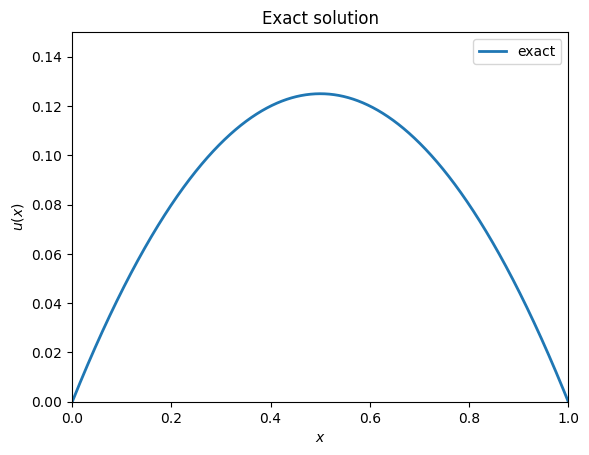

In [7]:
# Plot the exact solution
t = np.linspace(0.0, 1.0, 10001)
plt.figure()
plt.plot(t, u_exact(t), linewidth=2, label="exact")
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title("Exact solution")
plt.axis([0, 1, 0, 1.2*np.max(u_exact(t))])
plt.legend()
plt.show()

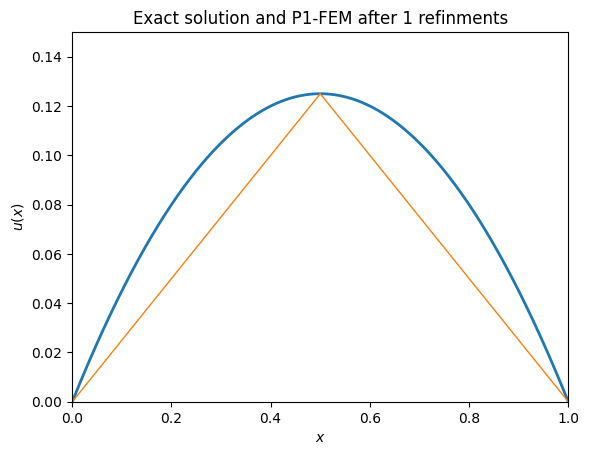

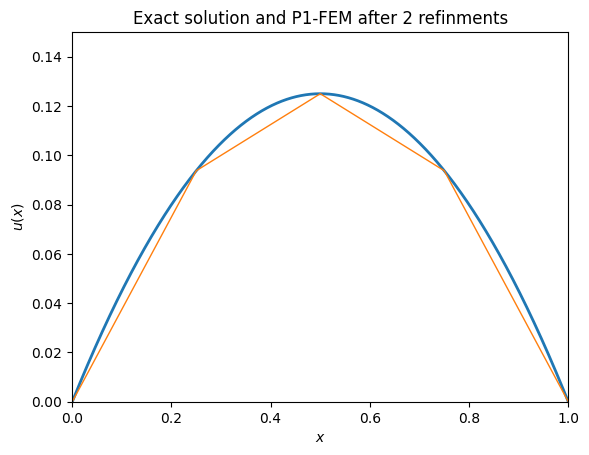

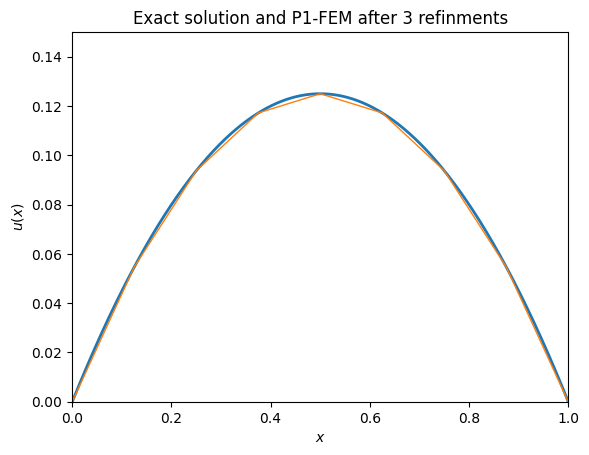

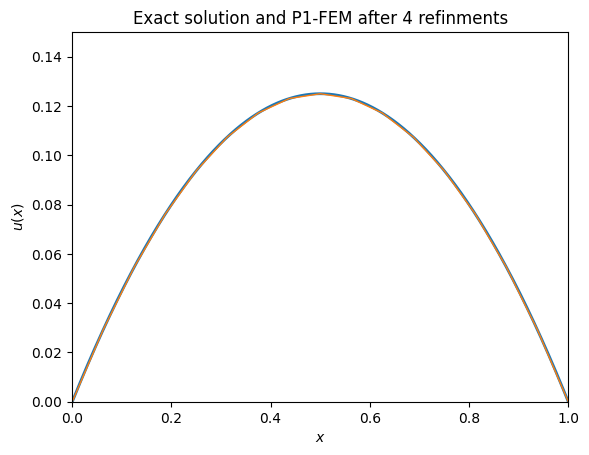

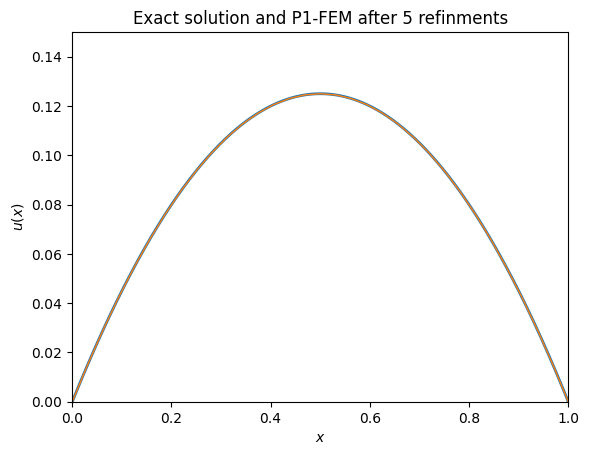

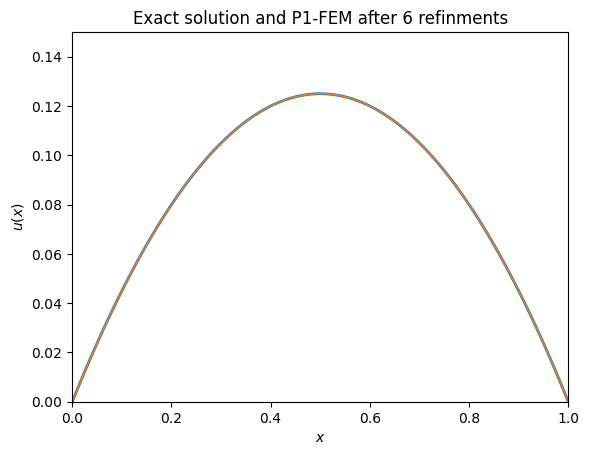

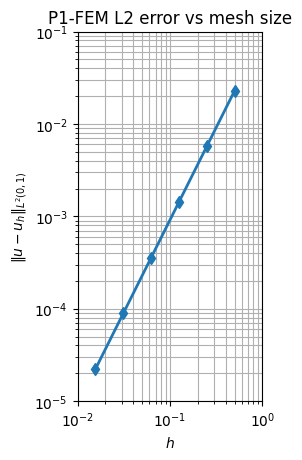

In [8]:
# P1 FEM on uniform meshes
num_levels = 6            # number of uniform refinement levels

err = np.zeros(num_levels) # L2 error for each level
hvals = np.zeros(num_levels)

for k in range(1, num_levels+1):
    # Prepare a figure for overlays (exact + a few FE lines)
    plt.figure()
    plt.plot(t, u_exact(t), linewidth=2, label="exact")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$u(x)$")
    plt.title("Exact solution and P1-FEM after "+str(k)+" refinments")
    plt.axis([0, 1, 0, 1.2*np.max(u_exact(t))])

    # mesh size
    N = 1 + 2**k                # number of grid points
    h = 1.0/(N-1)               # uniform mesh size
    hvals[k-1] = h
    x = np.linspace(0.0, 1.0, N)  # node coordinates

    # Assemble stiffness matrix for interior nodes (Dirichlet BCs)
    Ndof = N - 2                 # number of interior unknowns
    main_diag = (2.0/h) * np.ones(Ndof)
    off_diag  = (-1.0/h) * np.ones(Ndof-1) if Ndof > 1 else np.array([])
    K = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format="csc")

    # Right-hand side using nodal interpolant of f
    rhs = h * f(x[1:-1])

    # Solve K * uh_int = rhs
    uh_int = spsolve(K, rhs)

    # Full solution including boundary zeros
    uh = np.zeros(N)
    uh[1:-1] = uh_int

    # Optional overlays for the first few refinement levels
    plt.plot(x, uh, linewidth=1, label=f"FE k={k}")
    
    # Compute L2 error via 5-pt Gauss quadrature per element
    e2 = 0.0
    for j in range(N-1):
        xL, xR = x[j], x[j+1]
        hj = xR - xL
        slope = (uh[j+1] - uh[j]) / hj
        # Map gauss points from [-1,1] to [xL,xR]: x = xm + xr * xi
        xm = 0.5*(xR + xL)
        xr = 0.5*hj
        xq = xm + xr * g_xi
        uhq = uh[j] + slope * (xq - xL)
        rq = u_exact(xq) - uhq
        e2 += np.sum(g_w * (rq**2)) * xr
    err[k-1] = np.sqrt(e2)

plt.show()

# Log–log plot of L2 error vs mesh size h
plt.figure()
plt.loglog(hvals, err, "-d", linewidth=2)
plt.xlabel(r"$h$")
plt.ylabel(r"$\|u-u_h\|_{L^2(0,1)}$")
plt.title("P1-FEM L2 error vs mesh size")
plt.grid(True, which="both")
plt.axis([1e-2, 1, 1e-5, 1e-1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()